In [1]:
import seaborn as sb, pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from matplotlib_venn import venn2

In [2]:
df_train = pd.read_csv('../UNSW-NB15/data/UNSW_NB15_training-set.csv')
df_test = pd.read_csv('../UNSW-NB15/data/UNSW_NB15_testing-set.csv')

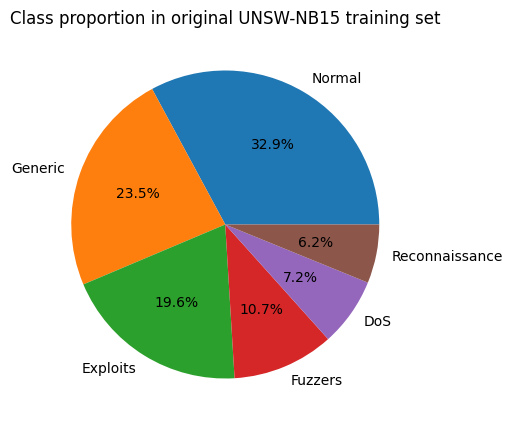

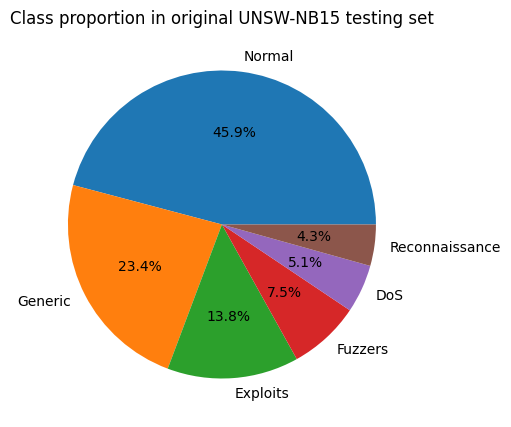

In [3]:
df_train["attack_cat"] = df_train["attack_cat"].apply(lambda x: x if x not in ('Worms', 'Analysis', 'Backdoor', 'Shellcode') else None) 
df_test["attack_cat"] = df_test["attack_cat"].apply(lambda x: x if x not in ('Worms', 'Analysis', 'Backdoor', 'Shellcode') else None) 

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

plt.figure(figsize=(12,5))
plt.title("Class proportion in original UNSW-NB15 training set")
plt.pie(df_train["attack_cat"].value_counts(normalize=True).values, labels=df_train["attack_cat"].value_counts(normalize=True).index, autopct='%.1f%%')
plt.show()

plt.figure(figsize=(12,5))
plt.title("Class proportion in original UNSW-NB15 testing set")
plt.pie(df_test["attack_cat"].value_counts(normalize=True).values, labels=df_test["attack_cat"].value_counts(normalize=True).index, autopct='%.1f%%')
plt.show()

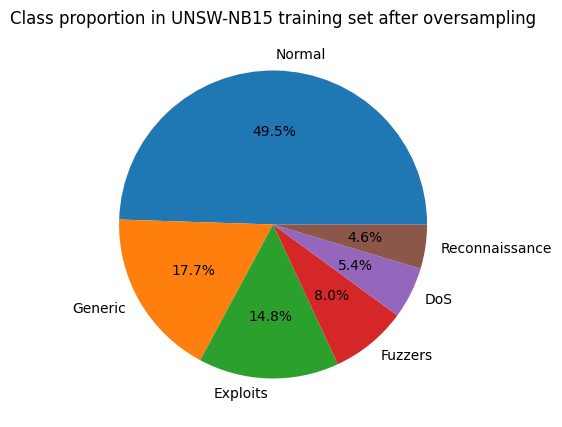

In [4]:
df_train_add = df_train[df_train["label"] == 0]

df_train = pd.concat([df_train,df_train_add])

plt.figure(figsize=(12,5))
plt.title("Class proportion in UNSW-NB15 training set after oversampling")
plt.pie(df_train["attack_cat"].value_counts(normalize=True).values, labels=df_train["attack_cat"].value_counts(normalize=True).index, autopct='%.1f%%')
plt.show()

In [5]:
numeric_cols = df_train.columns.difference(["service", "proto", "state", "attack_cat", "label"])
scaler = MinMaxScaler()
df_train[numeric_cols] = scaler.fit_transform(df_train[numeric_cols])
df_test[numeric_cols] = scaler.transform(df_test[numeric_cols])

In [6]:
enc = OrdinalEncoder().set_output(transform="pandas")
df_train["attack_cat"] = enc.fit_transform(df_train[["attack_cat"]])
df_test["attack_cat"] = enc.transform(df_test[["attack_cat"]])

df_train["attack_cat"] = df_train["attack_cat"].astype(int)
df_test["attack_cat"] = df_test["attack_cat"].astype(int)

In [7]:
enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False).set_output(transform="pandas")
df_train_trans_cats = enc.fit_transform(df_train[["service", "proto", "state"]])
df_test_trans_cats = enc.transform(df_test[["service",  "proto", "state"]])

df_train = pd.concat([df_train, df_train_trans_cats], axis=1).drop(["service", "proto", "state"], axis=1)
df_test = pd.concat([df_test, df_test_trans_cats], axis=1).drop(["service", "proto", "state"], axis=1)

df_train = df_train[[c for c in df_train if c not in ['attack_cat', 'label']] 
   + ['attack_cat', 'label']]
df_test = df_test[[c for c in df_test if c not in ['attack_cat', 'label']] 
   + ['attack_cat', 'label']]

print(df_train.shape)

(226332, 197)


In [8]:
del df_train["id"]
del df_test["id"]

In [9]:
df_test, df_validation = train_test_split(df_test, test_size=0.5, random_state=13, shuffle=True, stratify=df_test["attack_cat"])
print(len(df_test), len(df_validation))
print(df_test["attack_cat"].value_counts())
print(df_validation["attack_cat"].value_counts())

40325 40325
attack_cat
4    18500
3     9436
1     5566
2     3031
0     2044
5     1748
Name: count, dtype: int64
attack_cat
4    18500
3     9435
1     5566
2     3031
0     2045
5     1748
Name: count, dtype: int64


In [10]:
df_train_unduplicated = df_train.drop_duplicates()
X_train_num, y_train_und = df_train_unduplicated.iloc[:, 0:39],  df_train_unduplicated.iloc[:, -2]

In [11]:
mutual_info = mutual_info_classif(X_train_num, y_train_und)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train_num.columns
mutual_info = mutual_info.sort_values(ascending = False)

plt.figure(figsize=(12,5))
plt.title("Numeric feature importance ranking by Information Gain")
plt.bar(mutual_info.index, mutual_info, width=0.6, color="red")
plt.axhline(0.25, c="black", ls="--")
plt.xticks(rotation=90)
plt.show()

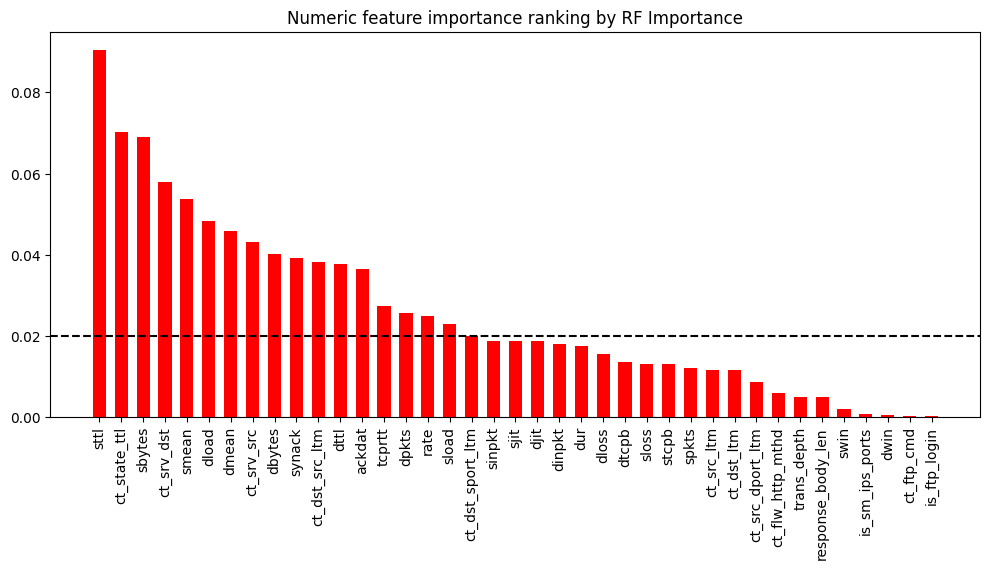

In [ ]:
clf = RandomForestClassifier(n_estimators=1000, random_state=13)
clf = clf.fit(X_train_num, y_train_und)
rf_info = pd.Series(clf.feature_importances_)
rf_info.index = X_train_num.columns
rf_info = rf_info.sort_values(ascending = False)
plt.figure(figsize=(12,5))
plt.title("Numeric feature importance ranking by RF Importance")
plt.bar(rf_info.index, rf_info, width=0.6, color="red")
plt.axhline(0.02, c="black", ls="--")
plt.xticks(rotation=90)
plt.show()

In [ ]:
mutual_info = mutual_info[mutual_info>0.25]
rf_info = rf_info[rf_info>0.02]
igrf_intersection = set(rf_info.index).intersection(set(mutual_info.index))
igrf_union = set(rf_info.index).union(set(mutual_info.index))
print("IG: ", len(mutual_info))
print("RF: ", len(rf_info))
print("IGRF Intersection: ", len(igrf_intersection))
print("IGRF Union: ", len(igrf_union))

IG:  22
RF:  17
IGRF Intersection:  15
IGRF Union:  24


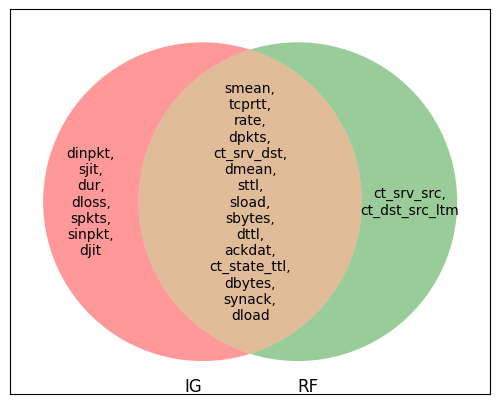

In [ ]:
plt.figure(figsize=(12,5))
venn = venn2(subsets = (3, 3, 5), set_labels=('IG', 'RF'))
venn.get_label_by_id('100').set_text(',\n'.join(set(mutual_info.index)-set(rf_info.index)))
venn.get_label_by_id('110').set_text(',\n'.join(set(mutual_info.index)&set(rf_info.index)))
venn.get_label_by_id('010').set_text(',\n'.join(set(rf_info.index)-set(mutual_info.index)))
plt.axis('on')
plt.show()

In [ ]:
result_df = pd.DataFrame(columns=["name", "accuracy", "precison", "recall", "f1-score"])

In [ ]:
def eval(name, X_train, y_train, X_test, y_test):
    model = MLPClassifier(random_state=13, max_iter=500)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    print(f"{name}")
    print("\nClassification report:\n")
    print(classification_report(y_test, y_preds))
    print("\nConfusion matrix:\n")
    print(confusion_matrix(y_test, y_preds))

    return (
        name,
        accuracy_score(y_test, y_preds)*100,
        precision_score(y_test, y_preds, average="weighted")*100,
        recall_score(y_test, y_preds, average="weighted"*100),
        f1_score(y_test, y_preds, average="weighted")*100        
    )

In [ ]:
X_train, y_train = df_train.iloc[:, 0:-2], df_train.iloc[:, -2]
X_test, y_test = df_test.iloc[:, 0:-2], df_test.iloc[:, -2]
result_df.loc[len(result_df.index)] = [*eval("all", X_train, y_train, X_test, y_test)]

d:\ProjectsInn\intrusion-detection\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


all

Classification report:

              precision    recall  f1-score   support

           0       0.23      0.06      0.09      2044
           1       0.57      0.80      0.67      5566
           2       0.24      0.09      0.14      3031
           3       1.00      0.96      0.98      9436
           4       0.86      0.90      0.88     18500
           5       0.47      0.63      0.54      1748

    accuracy                           0.78     40325
   macro avg       0.56      0.57      0.55     40325
weighted avg       0.76      0.78      0.76     40325


Confusion matrix:

[[  121  1698    57    11    91    66]
 [  218  4475   132    14   510   217]
 [  180   531   284     4  1916   116]
 [    0   238    57  9067    37    37]
 [    0   501   630     2 16573   794]
 [    4   413     4     1   232  1094]]


InvalidParameterError: The 'average' parameter of recall_score must be a str among {'samples', 'micro', 'binary', 'weighted', 'macro'} or None. Got 'weightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweightedweighted' instead.

In [ ]:
X_train_cat = df_train.iloc[:, 39:-2]
X_test_cat = df_test.iloc[:, 39:-2]

In [ ]:
X_train, y_train = np.concatenate((df_train[mutual_info.index], X_train_cat), axis=1),  df_train.iloc[:, -2]
X_test, y_test = np.concatenate((df_test[mutual_info.index], X_test_cat), axis=1),  df_test.iloc[:, -2]
result_df.loc[len(result_df.index)] = [*eval("info_gain", X_train, y_train, X_test, y_test)]

In [ ]:
X_train, y_train = np.concatenate((df_train[rf_info.index], X_train_cat), axis=1),  df_train.iloc[:, -2]
X_test, y_test = np.concatenate((df_test[rf_info.index], X_test_cat), axis=1),  df_test.iloc[:, -2]
result_df.loc[len(result_df.index)] = [*eval("rf_info", X_train, y_train, X_test, y_test)]

In [ ]:
X_train, y_train = np.concatenate((df_train[list(igrf_union)], X_train_cat), axis=1),  df_train.iloc[:, -2]
X_test, y_test = np.concatenate((df_test[list(igrf_union)], X_test_cat), axis=1),  df_test.iloc[:, -2]
result_df.loc[len(result_df.index)] = [*eval("igrf_union", X_train, y_train, X_test, y_test)]

In [ ]:
X_train, y_train = np.concatenate((df_train[list(igrf_intersection)], X_train_cat), axis=1),  df_train.iloc[:, -2]
X_test, y_test = np.concatenate((df_test[list(igrf_intersection)], X_test_cat), axis=1),  df_test.iloc[:, -2]
result_df.loc[len(result_df.index)] = [*eval("igrf_intersection", X_train, y_train, X_test, y_test)]

In [ ]:
result_dfm = pd.melt(result_df, id_vars=("name"), value_vars=("accuracy", "precison", "recall", "f1-score"), var_name="metric", value_name="percentage")
g = sb.FacetGrid(result_dfm, height=4, aspect=2, )
g.map_dataframe(sb.barplot, data=result_dfm, x="name", y="percentage", hue="metric", palette=["tab:red", "tab:green", "tab:orange", "tab:blue"])
g.fig.suptitle("Comparison of different feature selections")
g.add_legend()
g.tight_layout()

In [ ]:
# df_train.to_csv('../UNSW-NB15/data/UNSW_NB15_training-set_cleaned.csv', float_format='%f', index=False)
# df_test.to_csv('../UNSW-NB15/data/UNSW_NB15_testing-set_cleaned.csv', float_format='%f', index=False)